# Ranking Merchants

This notebook focuses on building the ranking system to find the top 100 best merchants for the BNPL firm to accept.

Metrics used:
1. BNPL Revenue = take rate x merchant revenue (average revenue for the last 3 months)
2. Weighted fraud probability of merchants
3. Repurchase rate of consumers
4. Growth rate of merchant 
5. Average consumer fraud probability of each merchant

In [51]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
CUR = Path("../data/curated")

In [38]:
tx = pd.read_parquet(CUR / "tx_imputed.parquet")
pred_revenue = pd.read_csv(CUR / "next_quarter_revenue_forecast.csv")

In [ ]:
# Check for columns with any missing values
null_counts = tx.isnull().sum()
null_cols = null_counts[null_counts > 0]

print("Columns with missing values and their counts:")
print(null_cols.sort_values(ascending=False))

Columns with missing values and their counts:
SA2_code    1890764
SA2_name    1890764
dtype: int64


In [ ]:
n_unique_merchants = tx["merchant_abn"].nunique()
print(f"Number of unique merchants: {n_unique_merchants}")

Number of unique merchants: 4026


### Calculate BNPL Revenue
**take rate * average merchant revenue in the last 3 months**

This was chosen because we want to find the top 100 merchants to partner with now, and thus our metric should reflect recent performance and not be dominated by old data. Using the total revenue over the entire dataset period, then merchants that were historically strong but have declining performance today will still appear at the top, which might not be ideal. Furthermore, many merchants experience seasonality (holidays, sales periods) and a snapshot that is too short (e.g., last 1 month) could over-represent seasonal spikes. Thus we decide to average over the last 3 months to smooth out noise but still reflects current demand.

In [39]:
tx["order_datetime"] = pd.to_datetime(tx["order_datetime"])

# Define recent window (last 3 months)
cutoff_date = tx["order_datetime"].max() - pd.DateOffset(months=3)
recent_tx = tx[tx["order_datetime"] >= cutoff_date]

# Aggregate
merchant_rev = (
    recent_tx.groupby("merchant_abn")
    .agg(total_revenue=("dollar_value", "sum"), take_rate=("take_rate", "mean"))
    .reset_index()
)

merchant_rev["monthly_avg_revenue"] = merchant_rev["total_revenue"] / 3
merchant_rev["bnpl_revenue"] = merchant_rev["monthly_avg_revenue"] * merchant_rev["take_rate"]
bnpl_rev = merchant_rev[["merchant_abn", "bnpl_revenue"]]
print(bnpl_rev.head(10))
print("Number of merchants: " + str(len(bnpl_rev)))

  merchant_abn   bnpl_revenue
0  10023283211    7407.479484
1  10142254217   30018.743322
2  10165489824   13331.255120
3  10187291046    7158.807373
4  10192359162   81529.927848
5  10206519221  132294.922914
6  10255988167   80956.869672
7  10264435225   88961.632916
8  10279061213   52917.782560
9  10323485998  504572.425283
Number of merchants: 3960


### Calculate Weighted Merchant Fraud Probability
 **Σ(dollar value * fraud probability)**

In [8]:
merchant_fraud_sum = (
    tx.groupby("merchant_abn", as_index=False)["tx_dollar_fraud"]
      .sum()
      .rename(columns={"tx_dollar_fraud": "total_tx_dollar_fraud"})
)

print(merchant_fraud_sum.head(10))
print("Number of merchants: " + str(len(merchant_fraud_sum)))

  merchant_abn  total_tx_dollar_fraud
0  10023283211          427596.760363
1  10142254217           70965.711194
2  10165489824           23880.677185
3  10187291046           25854.499826
4  10192359162          108124.705081
5  10206519221          216470.842381
6  10255988167          204738.343895
7  10264435225          353575.205904
8  10279061213          106349.380900
9  10323485998          636203.788859
Number of merchants: 4026


### Repurchase rate

This is the proportion of consumers who are repeat buyers for a given merchant.

In [9]:
merchant_repurchase = tx[["merchant_abn", "repurchase_rate"]].drop_duplicates()

print(merchant_repurchase.head(10))
print("Number of merchants: " + str(len(merchant_repurchase)))

  merchant_abn  repurchase_rate
0  78798828265         0.105428
1  60956456424         0.911273
2  94472466107         0.408794
3  49891706470         0.999751
4  82812059627         0.024202
5  17945458645         0.073618
6  21025433654         0.458126
7  57900494384         0.816016
8  94493496784         0.935207
9  68216911708         0.996260
Number of merchants: 4026


### Growth Rate of Merchant Revenue

For each merchant, we calculate the growth rate by comparing their forecasted revenue for the next quarter with their actual revenue from the previous quarter. This captures the expected percentage change in revenue, allowing us to identify merchants that are projected to expand rapidly or decline in performance. A positive growth rate indicates potential business momentum, while a negative rate highlights possible risks or slowdowns.

In [30]:
pred_revenue.head(5)

,merchant_abn,next_quarter_revenue
0,10023283211,145067.734375
1,10142254217,24538.424805
2,10165489824,16613.703369
3,10187291046,8188.844727
4,10192359162,33783.423828


In [37]:
merchant_rev.head(5)

0    10023283211
1    10142254217
2    10165489824
3    10187291046
4    10192359162
Name: merchant_abn, dtype: object

In [45]:
merchant_rev["merchant_abn"] = merchant_rev["merchant_abn"].astype(str)
pred_revenue["merchant_abn"] = pred_revenue["merchant_abn"].astype(str)

# Merge predicted and actual revenue
merchant_growth = merchant_rev.merge(
    pred_revenue, on="merchant_abn", how="inner"
)

# Calculate growth rate
merchant_growth["growth_rate"] = (
    (merchant_growth["next_quarter_revenue"] - merchant_growth["total_revenue"])
    / merchant_growth["total_revenue"]
)

# Format as percentage
merchant_growth["growth_rate_pct"] = merchant_growth["growth_rate"] * 100

# Keep only desired metrics
merchant_growth = merchant_growth[["merchant_abn", "growth_rate_pct"]]
print(merchant_growth.head())
print("Number of merchants: " + str(len(merchant_growth)))

  merchant_abn  growth_rate_pct
0  10023283211        17.503721
1  10142254217        14.986107
2  10165489824        82.779226
3  10187291046        25.445938
4  10192359162       -12.568273
Number of merchants: 3960


### Consumer Fraud Probability

For each merchant, calculate the average fraud risk of their customers, weighted by how much each customer spends.

In [13]:
# Compute weighted fraud contribution per transaction
tx["consumer_fraud_weighted_value"] = tx["dollar_value"] * tx["consumer_fraud_prob_avg"]

# Aggregate at (merchant, consumer) level
merchant_consumer_agg = (
    tx.groupby(["merchant_abn", "consumer_id"], as_index=False)
    .agg(fraud_weighted_sum=("consumer_fraud_weighted_value", "sum"))
)

# For each merchant, sum fraud-weighted spend and divide by number of unique consumers
merchant_fraud_risk = (
    merchant_consumer_agg.groupby("merchant_abn", as_index=False)
    .agg(
        total_fraud_weighted_spend=("fraud_weighted_sum", "sum"),
        n_unique_consumers=("consumer_id", "nunique")
    )
)

merchant_fraud_risk["avg_weighted_consumer_fraud"] = (
    merchant_fraud_risk["total_fraud_weighted_spend"] / merchant_fraud_risk["n_unique_consumers"]
)

# Keep only the final metric if desired
merchant_fraud_risk = merchant_fraud_risk[["merchant_abn", "avg_weighted_consumer_fraud"]]

print(merchant_fraud_risk.head(10))
print("Number of merchants: " + str(len(merchant_fraud_risk)))

  merchant_abn  avg_weighted_consumer_fraud
0  10023283211                    35.756104
1  10142254217                     6.384311
2  10165489824                  2558.413914
3  10187291046                    17.529688
4  10192359162                    71.539421
5  10206519221                     7.123286
6  10255988167                    61.100870
7  10264435225                    19.909153
8  10279061213                    46.692582
9  10323485998                    24.670214
Number of merchants: 4026


## Build Ranking System

Each of our merchant-level datasets contains 4026 merchants, except `bnpl_rev` and `merchant_growth`, which only includes 3963 merchants. This means that 63 merchants have no recorded transactions in the last three months. Since our ranking system is focused on identifying the best merchants for BNPL acceptance based on recent performance, including merchants with no recent activity would not provide meaningful insights as they generate no BNPL revenue and cannot contribute to near-term growth.

Therefore, we chose to use an inner join when combining these datasets, ensuring that only merchants with recent transaction data (and thus measurable BNPL revenue) are included in the final ranking. This keeps our results relevant and actionable for the business.

**Weighting Scheme:**

The weighting scheme for our merchant ranking system is designed to balance profitability, growth potential, customer engagement, and risk management, aligning with the BNPL firm’s strategic priorities. We assign the highest weight (**35%**) to **BNPL revenue**, as merchants who generate higher transaction volumes directly contribute to company profitability and market share. **Merchant growth rate** receives **20%**, emphasizing the importance of identifying emerging merchants with accelerating sales momentum, which is a key indicator of future profitability and partnership potential.

**Repurchase rate** is weighted at **15%**, reflecting the value of customer loyalty and sustained BNPL adoption. Merchants that encourage repeat purchases help strengthen long-term engagement across the platform. From a risk perspective, **weighted merchant fraud probability** is given **20%**, as minimizing exposure to fraudulent activity is crucial for maintaining healthy margins and protecting financial stability. Lastly, average **consumer fraud probability** is assigned **10%**, capturing the underlying risk profile of each merchant’s customer base without excessively penalizing merchants with slightly riskier consumers who still generate substantial growth and revenue.

In [46]:
# Merge all merchant-level metrics
merchant_metrics = (
    bnpl_rev.merge(merchant_fraud_sum, on="merchant_abn", how="inner")
            .merge(merchant_repurchase, on="merchant_abn", how="inner")
            .merge(merchant_fraud_risk, on="merchant_abn", how="inner")
            .merge(merchant_growth, on="merchant_abn", how="inner")
)

print(merchant_metrics.head(10))
print("Number of merchants: " + str(len(merchant_metrics)))

  merchant_abn   bnpl_revenue  total_tx_dollar_fraud  repurchase_rate  \
0  10023283211    7407.479484          427596.760363         0.071900   
1  10142254217   30018.743322           70965.711194         0.063882   
2  10165489824   13331.255120           23880.677185         0.000000   
3  10187291046    7158.807373           25854.499826         0.002985   
4  10192359162   81529.927848          108124.705081         0.005222   
5  10206519221  132294.922914          216470.842381         0.191899   
6  10255988167   80956.869672          204738.343895         0.019608   
7  10264435225   88961.632916          353575.205904         0.101654   
8  10279061213   52917.782560          106349.380900         0.009107   
9  10323485998  504572.425283          636203.788859         0.198334   

   avg_weighted_consumer_fraud  growth_rate_pct  
0                    35.756104        17.503721  
1                     6.384311        14.986107  
2                  2558.413914        82.77922

In [47]:
# Check for columns with any missing values
null_counts = merchant_metrics.isnull().sum()
null_cols = null_counts[null_counts > 0]

print("Columns with missing values and their counts:")
print(null_cols.sort_values(ascending=False))

Columns with missing values and their counts:
Series([], dtype: int64)


In [48]:
# Normalize each metric to [0,1] so they are on the same scale
scaler = MinMaxScaler()

merchant_metrics[["bnpl_revenue_norm", "fraud_sum_norm", "repurchase_norm", "avg_cons_fraud_norm", "growth_rate_norm"]] = scaler.fit_transform(
    merchant_metrics[["bnpl_revenue", "total_tx_dollar_fraud", "repurchase_rate", "avg_weighted_consumer_fraud", "growth_rate_pct"]]
)

# Invert risk metrics so that higher = better 
merchant_metrics["fraud_sum_norm_inv"] = 1 - merchant_metrics["fraud_sum_norm"]
merchant_metrics["avg_cons_fraud_norm_inv"] = 1 - merchant_metrics["avg_cons_fraud_norm"]

In [54]:
# Compute final score using weights 
merchant_metrics["final_score"] = (
    0.35 * merchant_metrics["bnpl_revenue_norm"] +
    0.2 * merchant_metrics["growth_rate_norm"] + 
    0.15 * merchant_metrics["repurchase_norm"] +
    0.2 * merchant_metrics["fraud_sum_norm_inv"] +
    0.1 * merchant_metrics["avg_cons_fraud_norm_inv"]
)

# Rank merchants
merchant_metrics = merchant_metrics.sort_values("final_score", ascending=False)

top_100_merchants = merchant_metrics.head(100)

# Display top merchants
print(top_100_merchants[["merchant_abn", "bnpl_revenue", "growth_rate_pct", "repurchase_rate",
                         "total_tx_dollar_fraud", "avg_weighted_consumer_fraud", "final_score"]])

     merchant_abn  bnpl_revenue  growth_rate_pct  repurchase_rate  \
3389  86578477987  3.552933e+06        -2.245407         0.999917   
1014  32361057556  3.616490e+06        -2.623261         0.899555   
1609  45629217853  3.393160e+06        -0.105443         0.999045   
1737  48534649627  3.665950e+06        -3.489012         0.814438   
510   21439773999  3.328034e+06        -2.706312         0.967341   
...           ...           ...              ...              ...   
3557  90568944804  2.330148e+06        -4.169899         0.200736   
552   22227727512  1.134227e+06        16.183098         0.295824   
493   21025433654  3.575211e+05        -1.138960         0.458126   
2413  64523396248  7.616873e+02      1497.895490         0.000000   
3732  94472466107  5.006363e+05        -7.190081         0.408794   

      total_tx_dollar_fraud  avg_weighted_consumer_fraud  final_score  
3389           2.656427e+06                    61.595394     0.623467  
1014           2.629309e+06

In [50]:
# Save to curated folder
merchant_metrics.to_parquet(CUR / "merchant_ranking.parquet", index=False)

### Visualize metrics of top 10 merchants 

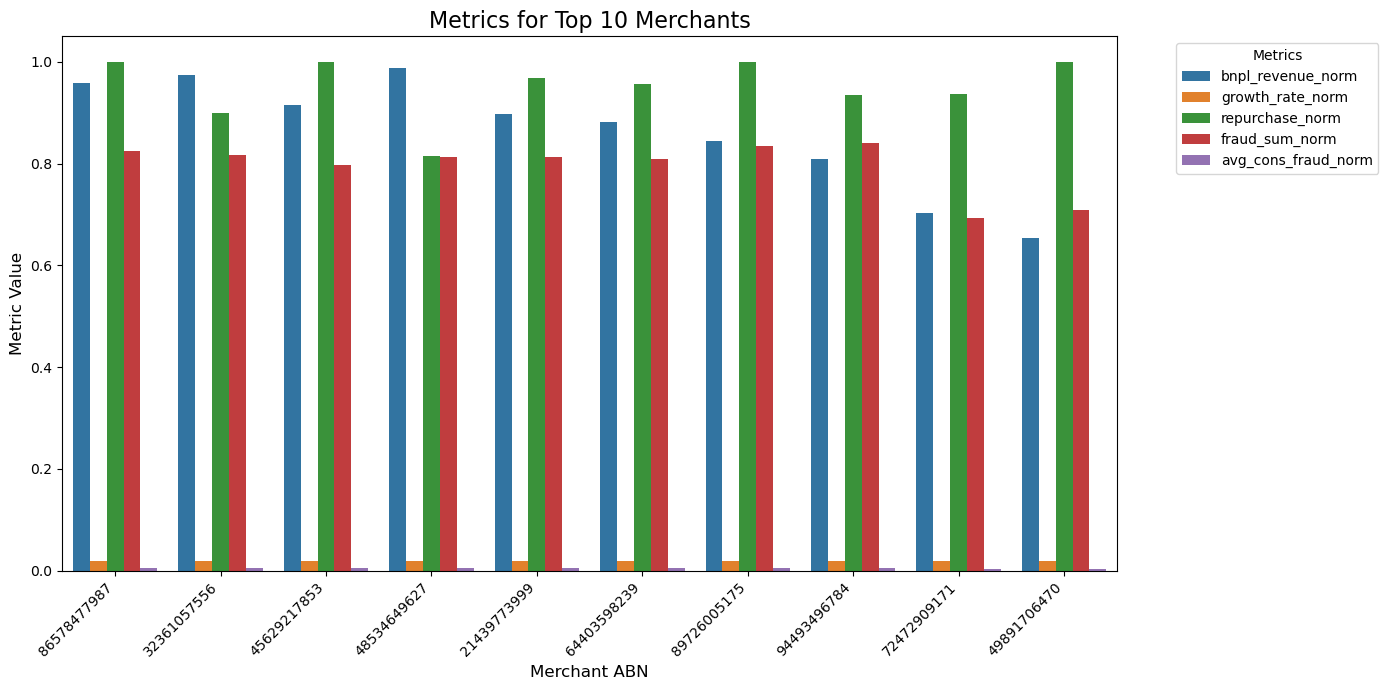

In [ ]:
# Select Top 10 Merchants 
top_10_merchants = top_100_merchants.head(10).copy()

# Melt the DataFrame to Long Format for Plotting
metrics_to_plot = [
    "bnpl_revenue_norm",
    "growth_rate_norm",
    "repurchase_norm",
    "fraud_sum_norm",
    "avg_cons_fraud_norm"
]

melted = top_10_merchants.melt(
    id_vars=["merchant_abn"],
    value_vars=metrics_to_plot,
    var_name="Metric",
    value_name="Value"
)

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(data=melted, x="merchant_abn", y="Value", hue="Metric")

plt.title("Metrics for Top 10 Merchants", fontsize=16)
plt.xlabel("Merchant ABN", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Overall, most top-performing merchants show strong BNPL revenue and high customer repurchase rates, indicating that they are both profitable and encourage repeat usage. However, their growth rates remain relatively low, suggesting that many are mature merchants with stable revenue streams rather than rapidly expanding ones. The fraud-related metrics (fraud sum and average consumer fraud) remain moderate across all merchants, meaning these top-ranked businesses maintain a manageable risk profile.

These results highlight that the BNPL firm’s leading partners are financially solid, have loyal customers, and maintain acceptable risk levels, making them strong candidates for continued collaboration and potential scaling initiatives.